In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier

In [2]:
# ✅ 1. 데이터 불러오기
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-2-1486842807>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [3]:

# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x) for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)  # 원본 URL 제거

In [4]:
# ✅ 3. HTML 피처 자동 추출
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [5]:
# ✅ 4. url_available 조건 적용
df['url_available'] = df['url_available'].fillna(0).astype(int)
for col in html_features:
    df[col] = df[col] * df['url_available']

In [6]:
# ✅ 5. file_ext 인코딩
if 'file_ext' in df.columns:
    le = LabelEncoder()
    df['file_ext'] = le.fit_transform(df['file_ext'])

In [7]:
# ✅ 6. 공통 기본 피처 정의
base_features = [col for col in df.columns if col not in ['label'] + html_features + ['url_available']]

In [8]:
# ✅ 7. 모델 평가 함수 정의
def evaluate_model(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LGBMClassifier(
        num_leaves=64,
        max_depth=10,
        learning_rate=0.05,
        n_estimators=500,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n===== 📊 결과: {model_name} =====")
    print("✅ Accuracy:", accuracy_score(y_test, y_pred))
    print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("📈 Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    return accuracy_score(y_test, y_pred)

In [9]:
# ✅ 8. A모델: HTML 피처 제외
X_a = df[base_features]
y = df['label']
acc_a = evaluate_model(X_a, y, "A모델 (HTML 피처 제외)")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 20
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [10]:
# ✅ 9. B모델: HTML 피처 포함 (url_available 조건 적용됨)
X_b = df[base_features + html_features]
acc_b = evaluate_model(X_b, y, "B모델 (HTML 피처 포함)")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 42
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [11]:
# ✅ 10. 비교 요약 출력
print("\n✅ 정확도 비교 요약:")
print(f"🔹 A모델 (HTML 제외): {acc_a:.4f}")
print(f"🔹 B모델 (HTML 포함): {acc_b:.4f}")
if acc_b > acc_a:
    print("👉 HTML 피처가 성능 향상에 기여함 ✅")
else:
    print("👉 HTML 피처가 성능 향상에 기여하지 않음 또는 미미함 ⚠️")


✅ 정확도 비교 요약:
🔹 A모델 (HTML 제외): 0.8335
🔹 B모델 (HTML 포함): 0.8335
👉 HTML 피처가 성능 향상에 기여하지 않음 또는 미미함 ⚠️


| 요인                      | 설명           |
| ----------------------- | ------------ |
| 대부분의 HTML 피처 값이 0       | 희소함, 의미 없음   |
| HTML이 있는 샘플이 적음         | 전체 모델에 영향 미미 |
| 기존 URL 기반 피처가 강력        | 추가 피처 필요성 적음 |
| HTML 구조와 공격 여부의 약한 상관관계 | 예측력 없음       |


In [12]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('real_final.csv')

# url_available == 1 인 샘플 수 확인
count_available = df[df['url_available'] == 1].shape[0]

print(f"url_available == 1인 데이터 개수: {count_available}")


<ipython-input-12-1227668369>:4: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv')


url_available == 1인 데이터 개수: 11554


In [ ]:
# 보조 모델

In [77]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from lightgbm import LGBMClassifier

In [78]:
# ✅ 1. 데이터 불러오기
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-78-1486842807>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [79]:
# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x) for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

In [80]:

# ✅ 3. HTML 피처 추출 + 결측값 처리
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [81]:
# ✅ 4. 데이터 분리
df_base = df[df['url_available'] == 0]  # 기본 모델용
df_html = df[df['url_available'] == 1]  # 보조 모델용

In [82]:
# ✅ 5. 기본 모델 (URL 기반만)
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
X_base = df_base[base_features]
y_base = df_base['label']

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

base_model = LGBMClassifier(random_state=42)
base_model.fit(X_base_train, y_base_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091741 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 20
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921


LGBMClassifier(random_state=42)

In [83]:
# ✅ 6. 보조 모델 (HTML + URL 기반)
features_all = base_features + html_features
X_html = df_html[features_all]
y_html = df_html['label']

X_html_train, X_html_test, y_html_train, y_html_test = train_test_split(X_html, y_html, test_size=0.2, random_state=42)

html_model = LGBMClassifier(random_state=42)
html_model.fit(X_html_train, y_html_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 8537, number of used features: 45
[LightGBM] [Info] Start training from score -0.617919
[LightGBM] [Info] Start training from score -1.828140
[LightGBM] [Info] Start training from score -1.203231


LGBMClassifier(random_state=42)

In [84]:
# ✅ 7. 각각 예측 및 평가
print("\n✅ [기본 모델 평가] (HTML 없음)")
y_base_pred = base_model.predict(X_base_test)
print("Accuracy:", accuracy_score(y_base_test, y_base_pred))
print(classification_report(y_base_test, y_base_pred, digits=4))

print("\n✅ [보조 모델 평가] (HTML 있음)")
y_html_pred = html_model.predict(X_html_test)
print("Accuracy:", accuracy_score(y_html_test, y_html_pred))
print(classification_report(y_html_test, y_html_pred, digits=4))


✅ [기본 모델 평가] (HTML 없음)
Accuracy: 0.8272164783840964
              precision    recall  f1-score   support

         0.0     0.8528    0.8841    0.8682     66959
         1.0     0.9355    0.8382    0.8842     20483
         2.0     0.7268    0.7205    0.7236     37813

    accuracy                         0.8272    125255
   macro avg     0.8384    0.8143    0.8253    125255
weighted avg     0.8283    0.8272    0.8272    125255


✅ [보조 모델 평가] (HTML 있음)
Accuracy: 0.8159250585480093
              precision    recall  f1-score   support

         0.0     0.8447    0.8760    0.8601      1105
         1.0     0.9180    0.8083    0.8597       360
         2.0     0.7188    0.7209    0.7198       670

    accuracy                         0.8159      2135
   macro avg     0.8271    0.8017    0.8132      2135
weighted avg     0.8175    0.8159    0.8160      2135



In [ ]:
# 오버 샘플링

In [59]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from lightgbm import LGBMClassifier

In [60]:
# ✅ 1. 데이터 로드
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-60-248958065>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [61]:
# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x) for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

In [62]:

# ✅ 3. HTML 피처 자동 추출 + 결측값 처리
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [63]:
# ✅ 4. 데이터 분리
df_base = df[df['url_available'] == 0]  # 기본 모델용
df_html = df[df['url_available'] == 1]  # 보조 모델용

In [64]:
# ✅ 5. 기본 피처 리스트
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [65]:
# ✅ 6. 기본 모델 학습 (url_available == 0)
X_base = df_base[base_features]
y_base = df_base['label']

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

base_model = LGBMClassifier(random_state=42)
base_model.fit(X_base_train, y_base_train)

print("\n✅ [기본 모델 평가] (HTML 없음)")
y_base_pred = base_model.predict(X_base_test)
print("Accuracy:", accuracy_score(y_base_test, y_base_pred))
print(classification_report(y_base_test, y_base_pred, digits=4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 20
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921

✅ [기본 모델 평가] (HTML 없음)
Accuracy: 0.8272164783840964
              precision    recall  f1-score   support

         0.0     0.8528    0.8841    0.8682     66959
         1.0     0.9355    0.8382    0.8842     20483
         2.0     0.7268    0.7205    0.7236     37813

    accuracy                         0.8272    125255
   macro avg     0.8384    0.8143    0.8253    125255
weighted avg     0.8283    0.8272    0.8272    125255



In [66]:
# ✅ 7. 보조 모델 오버샘플링
df_html_upsampled = resample(
    df_html,
    replace=True,
    n_samples=20000,  # 원하는 수만큼 늘릴 수 있음
    random_state=42
)

In [67]:
# ✅ 8. 보조 모델 학습 (HTML 있음)
X_html = df_html_upsampled[features_all]
y_html = df_html_upsampled['label']

X_html_train, X_html_test, y_html_train, y_html_test = train_test_split(X_html, y_html, test_size=0.2, random_state=42)

html_model = LGBMClassifier(random_state=42)
html_model.fit(X_html_train, y_html_train)

print("\n✅ [오버샘플링 후 보조 모델 평가] (HTML 있음)")
y_html_pred = html_model.predict(X_html_test)
print("Accuracy:", accuracy_score(y_html_test, y_html_pred))
print(classification_report(y_html_test, y_html_pred, digits=4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 45
[LightGBM] [Info] Start training from score -0.640673
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.177858

✅ [오버샘플링 후 보조 모델 평가] (HTML 있음)
Accuracy: 0.892
              precision    recall  f1-score   support

         0.0     0.8995    0.9332    0.9160      2081
         1.0     0.9632    0.9025    0.9319       667
         2.0     0.8421    0.8179    0.8298      1252

    accuracy                         0.8920      4000
   macro avg     0.9016    0.8845    0.8926      4000
weighted avg     0.8922    0.8920    0.8917      4000



NameError: name 'y_test' is not defined

n_samples=20000 일때 정확도 89.2


In [ ]:
# 혼동 매트릭스 추가 83%

In [49]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier

In [50]:
# ✅ 1. 데이터 불러오기
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-50-1486842807>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [51]:

# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x) for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

In [52]:
# ✅ 3. HTML 피처 추출 + 결측값 처리
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [53]:
# ✅ 4. 데이터 분리
df_base = df[df['url_available'] == 0]  # 기본 모델용
df_html = df[df['url_available'] == 1]  # 보조 모델용

In [54]:
# ✅ 5. 기본 피처 목록
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [55]:

# ✅ 6. 기본 모델 학습 (HTML 없음)
X_base = df_base[base_features]
y_base = df_base['label']
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

base_model = LGBMClassifier(random_state=42)
base_model.fit(X_base_train, y_base_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 20
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921


LGBMClassifier(random_state=42)

In [56]:
# ✅ 7. 보조 모델 학습 (HTML 포함)
X_html = df_html[features_all]
y_html = df_html['label']
X_html_train, X_html_test, y_html_train, y_html_test = train_test_split(X_html, y_html, test_size=0.2, random_state=42)

html_model = LGBMClassifier(random_state=42)
html_model.fit(X_html_train, y_html_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 8537, number of used features: 45
[LightGBM] [Info] Start training from score -0.617919
[LightGBM] [Info] Start training from score -1.828140
[LightGBM] [Info] Start training from score -1.203231


LGBMClassifier(random_state=42)

In [57]:
# ✅ 8. 기본 모델 평가
print("\n✅ [기본 모델 평가] (HTML 없음)")
y_base_pred = base_model.predict(X_base_test)
print("Accuracy:", accuracy_score(y_base_test, y_base_pred))
print(classification_report(y_base_test, y_base_pred, digits=4))
print("Confusion Matrix:")
print(np.array2string(confusion_matrix(y_base_test, y_base_pred), separator=' '))



✅ [기본 모델 평가] (HTML 없음)
Accuracy: 0.8272164783840964
              precision    recall  f1-score   support

         0.0     0.8528    0.8841    0.8682     66959
         1.0     0.9355    0.8382    0.8842     20483
         2.0     0.7268    0.7205    0.7236     37813

    accuracy                         0.8272    125255
   macro avg     0.8384    0.8143    0.8253    125255
weighted avg     0.8283    0.8272    0.8272    125255

Confusion Matrix:
[[59201   242  7516]
 [  588 17169  2726]
 [ 9629   941 27243]]


In [58]:
# ✅ 9. 보조 모델 평가
print("\n✅ [보조 모델 평가] (HTML 있음)")
y_html_pred = html_model.predict(X_html_test)
print("Accuracy:", accuracy_score(y_html_test, y_html_pred))
print(classification_report(y_html_test, y_html_pred, digits=4))
print("Confusion Matrix:")
print(np.array2string(confusion_matrix(y_html_test, y_html_pred), separator=' '))


✅ [보조 모델 평가] (HTML 있음)
Accuracy: 0.8159250585480093
              precision    recall  f1-score   support

         0.0     0.8447    0.8760    0.8601      1105
         1.0     0.9180    0.8083    0.8597       360
         2.0     0.7188    0.7209    0.7198       670

    accuracy                         0.8159      2135
   macro avg     0.8271    0.8017    0.8132      2135
weighted avg     0.8175    0.8159    0.8160      2135

Confusion Matrix:
[[968   6 131]
 [ 11 291  58]
 [167  20 483]]


In [ ]:
# 혼동 행렬 출력 89%

In [68]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
from lightgbm import LGBMClassifier

In [69]:
# ✅ 1. 데이터 로드
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-69-248958065>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [70]:
# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x) for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

In [71]:
# ✅ 3. HTML 피처 자동 추출 + 결측값 처리
html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [72]:
# ✅ 4. 데이터 분리
df_base = df[df['url_available'] == 0]  # 기본 모델용
df_html = df[df['url_available'] == 1]  # 보조 모델용

In [73]:

# ✅ 5. 피처 리스트 정의
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [74]:
# ✅ 6. 기본 모델 학습
X_base = df_base[base_features]
y_base = df_base['label']
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

base_model = LGBMClassifier(random_state=42)
base_model.fit(X_base_train, y_base_train)

print("\n✅ [기본 모델 평가] (HTML 없음)")
y_base_pred = base_model.predict(X_base_test)
print("Accuracy:", accuracy_score(y_base_test, y_base_pred))
print(classification_report(y_base_test, y_base_pred, digits=4))
print("Confusion Matrix:")
print(np.array2string(confusion_matrix(y_base_test, y_base_pred), separator=' '))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 20
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921

✅ [기본 모델 평가] (HTML 없음)
Accuracy: 0.8272164783840964
              precision    recall  f1-score   support

         0.0     0.8528    0.8841    0.8682     66959
         1.0     0.9355    0.8382    0.8842     20483
         2.0     0.7268    0.7205    0.7236     37813

    accuracy                         0.8272    125255
   macro avg     0.8384    0.8143    0.8253    125255
weighted avg     0.8283    0.8272    0.8272    125255

Confusion Matrix:
[[59201   242  7516]
 [  588 171

In [75]:

# ✅ 7. 보조 모델 오버샘플링
df_html_upsampled = resample(
    df_html,
    replace=True,
    n_samples=20000,
    random_state=42
)

In [76]:
# ✅ 8. 보조 모델 학습
X_html = df_html_upsampled[features_all]
y_html = df_html_upsampled['label']
X_html_train, X_html_test, y_html_train, y_html_test = train_test_split(X_html, y_html, test_size=0.2, random_state=42)

html_model = LGBMClassifier(random_state=42)
html_model.fit(X_html_train, y_html_train)

print("\n✅ [오버샘플링 후 보조 모델 평가] (HTML 있음)")
y_html_pred = html_model.predict(X_html_test)
print("Accuracy:", accuracy_score(y_html_test, y_html_pred))
print(classification_report(y_html_test, y_html_pred, digits=4))
print("Confusion Matrix:")
print(np.array2string(confusion_matrix(y_html_test, y_html_pred), separator=' '))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 45
[LightGBM] [Info] Start training from score -0.640673
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.177858

✅ [오버샘플링 후 보조 모델 평가] (HTML 있음)
Accuracy: 0.892
              precision    recall  f1-score   support

         0.0     0.8995    0.9332    0.9160      2081
         1.0     0.9632    0.9025    0.9319       667
         2.0     0.8421    0.8179    0.8298      1252

    accuracy                         0.8920      4000
   macro avg     0.9016    0.8845    0.8926      4000
weighted avg     0.8922    0.8920    0.8917      4000

Confusion Matrix:
[[1942    3  136]
 [   9  602   56]
 [

In [ ]:
# 피처 값 치환

In [85]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from lightgbm import LGBMClassifier

In [86]:
# ✅ 1. 데이터 로드
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

<ipython-input-86-248958065>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [87]:
# ✅ 2. 공통 피처 생성
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

In [88]:

# ✅ 3. HTML 피처 자동 추출 + 결측값 처리
html_features = [col for col in df.columns if col.startswith("html_")]

In [89]:
# ✅ 'html_is_shortened' → 'url_is_shortened'으로 이름 변경
if 'html_is_shortened' in df.columns:
    df.rename(columns={'html_is_shortened': 'url_is_shortened'}, inplace=True)
    html_features = [f if f != 'html_is_shortened' else 'url_is_shortened' for f in html_features]

df[html_features] = df[html_features].fillna(0)

In [90]:
# ✅ 4. 데이터 분리
df_base = df[df['url_available'] == 0]  # 기본 모델용
df_html = df[df['url_available'] == 1]  # 보조 모델용

In [91]:
# ✅ 5. 기본 피처 리스트
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [92]:
# ✅ 6. 기본 모델 학습 (url_available == 0)
X_base = df_base[base_features]
y_base = df_base['label']

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

base_model = LGBMClassifier(random_state=42)
base_model.fit(X_base_train, y_base_train)

print("\n✅ [기본 모델 평가] (HTML 없음)")
y_base_pred = base_model.predict(X_base_test)
print("Accuracy:", accuracy_score(y_base_test, y_base_pred))
print(classification_report(y_base_test, y_base_pred, digits=4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 19
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921

✅ [기본 모델 평가] (HTML 없음)
Accuracy: 0.827775338309848
              precision    recall  f1-score   support

         0.0     0.8531    0.8840    0.8683     66959
         1.0     0.9367    0.8400    0.8857     20483
         2.0     0.7275    0.7216    0.7245     37813

    accuracy                         0.8278    125255
   macro avg     0.8391    0.8152    0.8262    125255
weighted avg     0.8289    0.8278    0.8277    125255



In [93]:
# ✅ 7. 보조 모델 오버샘플링
df_html_upsampled = resample(
    df_html,
    replace=True,
    n_samples=20000,
    random_state=42
)

In [94]:

# ✅ 8. 보조 모델 학습 (HTML 있음)
X_html = df_html_upsampled[features_all]
y_html = df_html_upsampled['label']

X_html_train, X_html_test, y_html_train, y_html_test = train_test_split(X_html, y_html, test_size=0.2, random_state=42)

html_model = LGBMClassifier(random_state=42)
html_model.fit(X_html_train, y_html_train)

print("\n✅ [오버샘플링 후 보조 모델 평가] (HTML 있음)")
y_html_pred = html_model.predict(X_html_test)
print("Accuracy:", accuracy_score(y_html_test, y_html_pred))
print(classification_report(y_html_test, y_html_pred, digits=4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 45
[LightGBM] [Info] Start training from score -0.640673
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.177858

✅ [오버샘플링 후 보조 모델 평가] (HTML 있음)
Accuracy: 0.892
              precision    recall  f1-score   support

         0.0     0.8995    0.9332    0.9160      2081
         1.0     0.9632    0.9025    0.9319       667
         2.0     0.8421    0.8179    0.8298      1252

    accuracy                         0.8920      4000
   macro avg     0.9016    0.8845    0.8926      4000
weighted avg     0.8922    0.8920    0.8917      4000



In [ ]:
# 앙상블 하이브리드 모델

In [105]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    precision_recall_curve
)
from lightgbm import LGBMClassifier

In [106]:
# ✅ 1. 데이터 로드 및 전처리
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

<ipython-input-106-4196564853>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [107]:
# ✅ 2. HTML 피처 구성
if 'html_is_shortened' in df.columns:
    df.rename(columns={'html_is_shortened': 'url_is_shortened'}, inplace=True)

df['url_available'] = df['url_available'].fillna(0).astype(int)
html_features = [col for col in df.columns if col.startswith("html_") or col == 'url_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [108]:

# ✅ 3. 피처 목록 구성
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [109]:
# ✅ 4. 데이터 분리
df_base = df[df['url_available'] == 0]               # 메인 모델용
df_html = df[df['url_available'] == 1]               # 보조 모델용
df_html_upsampled = resample(df_html, replace=True, n_samples=30000, random_state=42)


In [110]:
# ✅ 5. SelectKBest로 HTML 피처 중 상위 10개 추출
X_html_raw = df_html_upsampled[html_features]
y_html_raw = df_html_upsampled['label']
selector = SelectKBest(score_func=f_classif, k=10)
X_html_selected = selector.fit_transform(X_html_raw, y_html_raw)
selected_html_features = [html_features[i] for i in selector.get_support(indices=True)]
final_features_html = base_features + selected_html_features

In [111]:
# ✅ 6. 메인 모델 학습 (기존 URL 기반)
X_main = df_base[base_features]
y_main = df_base['label']
X_main_train, X_main_test, y_main_train, y_main_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)

main_model = LGBMClassifier(random_state=42)
main_model.fit(X_main_train, y_main_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 19
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921


LGBMClassifier(random_state=42)

In [112]:
# ✅ 7. 보조 모델 학습 (HTML 기반 + feature selection)
X_sub = df_html_upsampled[final_features_html]
y_sub = df_html_upsampled['label']
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

sub_model = LGBMClassifier(random_state=42)
sub_model.fit(X_sub_train, y_sub_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1548
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 29
[LightGBM] [Info] Start training from score -0.640239
[LightGBM] [Info] Start training from score -1.815796
[LightGBM] [Info] Start training from score -1.170780


LGBMClassifier(random_state=42)

In [113]:

# ✅ 8. 전체 데이터에 대한 Soft Voting 예측
X_eval_main = df[base_features]
X_eval_sub = df[final_features_html]
y_eval = df['label'].values
mask = df['url_available'] == 1

# 각 모델의 예측 확률
main_proba = main_model.predict_proba(X_eval_main)
sub_proba = np.zeros_like(main_proba)
sub_proba[mask] = sub_model.predict_proba(X_eval_sub[mask])

# Soft Voting 조합
alpha, beta = 0.7, 0.3
final_proba = alpha * main_proba + beta * sub_proba
final_pred = np.argmax(final_proba, axis=1)

In [114]:
# ✅ 9. 평가 출력
print("\n✅ [Soft Voting Hybrid Model 평가]")
print("🎯 Accuracy:", accuracy_score(y_eval, final_pred))
print("🎯 Macro F1 Score:", f1_score(y_eval, final_pred, average='macro'))
print("\n📊 Classification Report:\n", classification_report(y_eval, final_pred, digits=4))



✅ [Soft Voting Hybrid Model 평가]
🎯 Accuracy: 0.8302720965612308
🎯 Macro F1 Score: 0.8284763960349384

📊 Classification Report:
               precision    recall  f1-score   support

         0.0     0.8558    0.8854    0.8703    340466
         1.0     0.9396    0.8394    0.8867    104968
         2.0     0.7295    0.7273    0.7284    191509

    accuracy                         0.8303    636943
   macro avg     0.8416    0.8174    0.8285    636943
weighted avg     0.8316    0.8303    0.8304    636943



In [ ]:
# 하이브리드 2

In [115]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score
from lightgbm import LGBMClassifier

In [116]:
# ✅ 1. 데이터 로드 및 전처리
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

<ipython-input-116-4196564853>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [117]:
# ✅ 2. HTML 피처 및 설정
if 'html_is_shortened' in df.columns:
    df.rename(columns={'html_is_shortened': 'url_is_shortened'}, inplace=True)

df['url_available'] = df['url_available'].fillna(0).astype(int)
html_features = [col for col in df.columns if col.startswith("html_") or col == 'url_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [118]:
# ✅ 3. 피처 분리
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [119]:
# ✅ 4. 보조모델 데이터 오버샘플링 + Feature Selection
df_html = df[df['url_available'] == 1]
df_html_upsampled = resample(df_html, replace=True, n_samples=30000, random_state=42)

X_html_raw = df_html_upsampled[html_features]
y_html_raw = df_html_upsampled['label']
selector = SelectKBest(score_func=f_classif, k=10)
X_html_selected = selector.fit_transform(X_html_raw, y_html_raw)
selected_html_features = [html_features[i] for i in selector.get_support(indices=True)]
features_B = base_features + selected_html_features  # 보조 모델 피처

In [120]:
# ✅ 5. A 모델 학습 (URL 기반 메인 모델)
X_A = df[base_features]
y = df['label']
X_A_train, X_A_test, y_train, y_test = train_test_split(X_A, y, test_size=0.2, random_state=42)

model_A = LGBMClassifier(random_state=42)
model_A.fit(X_A_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 19
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537


LGBMClassifier(random_state=42)

In [121]:

# ✅ 6. B 모델 학습 (HTML 포함 보조 모델)
X_B = df[features_B]
X_B_train, X_B_test, _, _ = train_test_split(X_B, y, test_size=0.2, random_state=42)

model_B = LGBMClassifier(random_state=42)
model_B.fit(X_B_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 29
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537


LGBMClassifier(random_state=42)

In [122]:

# ✅ 7. Soft Voting 앙상블 예측
proba_A = model_A.predict_proba(X_A_test)
proba_B = model_B.predict_proba(X_B_test)

# Soft voting
alpha, beta = 0.5, 0.5  # → GridSearch로 튜닝 가능
proba_final = alpha * proba_A + beta * proba_B
pred_final = np.argmax(proba_final, axis=1)

In [123]:
# ✅ 8. 평가
print("\n✅ [A + B Soft Voting 앙상블 평가]")
print("Accuracy:", accuracy_score(y_test, pred_final))
print("Macro F1 Score:", f1_score(y_test, pred_final, average='macro'))
print("\n📊 Classification Report:\n", classification_report(y_test, pred_final, digits=4))


✅ [A + B Soft Voting 앙상블 평가]
Accuracy: 0.8287450250806585
Macro F1 Score: 0.8262995204193037

📊 Classification Report:
               precision    recall  f1-score   support

         0.0     0.8551    0.8853    0.8699     68138
         1.0     0.9373    0.8352    0.8833     20981
         2.0     0.7268    0.7245    0.7257     38270

    accuracy                         0.8287    127389
   macro avg     0.8397    0.8150    0.8263    127389
weighted avg     0.8301    0.8287    0.8288    127389



In [ ]:
#하이브리드+가중치 늘리기

In [124]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score
from lightgbm import LGBMClassifier

In [125]:
# ✅ 1. 데이터 로드 및 전처리
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

<ipython-input-125-4196564853>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [126]:
# ✅ 2. HTML 피처 처리
if 'html_is_shortened' in df.columns:
    df.rename(columns={'html_is_shortened': 'url_is_shortened'}, inplace=True)

df['url_available'] = df['url_available'].fillna(0).astype(int)
html_features = [col for col in df.columns if col.startswith("html_") or col == 'url_is_shortened']
df[html_features] = df[html_features].fillna(0)

In [127]:
# ✅ 3. 피처 분리
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

In [128]:
# ✅ 4. 보조 모델용 데이터 오버샘플링 + Feature Selection
df_html = df[df['url_available'] == 1]
df_html_upsampled = resample(df_html, replace=True, n_samples=30000, random_state=42)

X_html_raw = df_html_upsampled[html_features]
y_html_raw = df_html_upsampled['label']
selector = SelectKBest(score_func=f_classif, k=10)
X_html_selected = selector.fit_transform(X_html_raw, y_html_raw)
selected_html_features = [html_features[i] for i in selector.get_support(indices=True)]
features_B = base_features + selected_html_features

In [129]:
# ✅ 5. A 모델 학습 (URL 기반)
X_A = df[base_features]
y = df['label']
X_A_train, X_A_test, y_train, y_test = train_test_split(X_A, y, test_size=0.2, random_state=42)

model_A = LGBMClassifier(random_state=42)
model_A.fit(X_A_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 19
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537


LGBMClassifier(random_state=42)

In [131]:
X_B = df[features_B]
y_B = df['label']  # 보조 모델의 y

X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y_B, test_size=0.2, random_state=42)

model_B = LGBMClassifier(random_state=42)
model_B.fit(X_B_train, y_B_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 29
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537


LGBMClassifier(random_state=42)

In [132]:
# ✅ 7. Soft Voting 기반 하이브리드 앙상블 예측
X_eval_A = df[base_features]
X_eval_B = df[features_B]
y_eval = df['label'].values
mask = df['url_available'] == 1

# 두 모델 모두 예측 수행
proba_A = model_A.predict_proba(X_eval_A)
proba_B = np.zeros_like(proba_A)
proba_B[mask] = model_B.predict_proba(X_eval_B[mask])

# 가중치 기반 Soft Voting
alpha, beta = 0.4, 0.6  # B 모델(보조)에 더 큰 가중치 부여
proba_final = alpha * proba_A + beta * proba_B
final_pred = np.argmax(proba_final, axis=1)

In [133]:
# ✅ 8. 평가
print("\n✅ [Hybrid + Weighted Soft Voting 모델 평가]")
print("🎯 Accuracy:", accuracy_score(y_eval, final_pred))
print("🎯 Macro F1 Score:", f1_score(y_eval, final_pred, average='macro'))
print("\n📊 Classification Report:\n", classification_report(y_eval, final_pred, digits=4))



✅ [Hybrid + Weighted Soft Voting 모델 평가]
🎯 Accuracy: 0.8301747566108741
🎯 Macro F1 Score: 0.8282537690112025

📊 Classification Report:
               precision    recall  f1-score   support

         0.0     0.8554    0.8858    0.8704    340466
         1.0     0.9399    0.8383    0.8862    104968
         2.0     0.7296    0.7268    0.7282    191509

    accuracy                         0.8302    636943
   macro avg     0.8417    0.8170    0.8283    636943
weighted avg     0.8315    0.8302    0.8302    636943



In [ ]:
# 84% 도전~

In [134]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score
from lightgbm import LGBMClassifier

In [135]:
# ✅ 1. 데이터 전처리
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])

df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

if 'html_is_shortened' in df.columns:
    df.rename(columns={'html_is_shortened': 'url_is_shortened'}, inplace=True)

df['url_available'] = df['url_available'].fillna(0).astype(int)
html_features = [col for col in df.columns if col.startswith("html_") or col == 'url_is_shortened']
df[html_features] = df[html_features].fillna(0)
base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features

<ipython-input-135-1282586086>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [136]:
# ✅ 2. 보조 모델용 데이터 오버샘플링 및 피처 선택
df_html = df[df['url_available'] == 1]
df_html_upsampled = resample(df_html, replace=True, n_samples=30000, random_state=42)

X_html_raw = df_html_upsampled[html_features]
y_html_raw = df_html_upsampled['label']
selector = SelectKBest(score_func=f_classif, k=10)
X_html_selected = selector.fit_transform(X_html_raw, y_html_raw)
selected_html_features = [html_features[i] for i in selector.get_support(indices=True)]
features_B = base_features + selected_html_features

In [137]:
# ✅ 3. 데이터 분리
X_A = df[base_features]
y = df['label']
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y, test_size=0.2, random_state=42)

X_B = df[features_B]
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y, test_size=0.2, random_state=42)


In [138]:
# ✅ 4. 하이퍼파라미터 튜닝 설정
params = {
    'num_leaves': [31, 64],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}


In [139]:
# ✅ 5. A 모델 튜닝
grid_A = GridSearchCV(
    LGBMClassifier(random_state=42),
    params,
    scoring='accuracy',
    cv=3,
    verbose=0
)
grid_A.fit(X_A_train, y_A_train)
best_model_A = grid_A.best_estimator_

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [140]:
# ✅ 6. B 모델 튜닝
grid_B = GridSearchCV(
    LGBMClassifier(random_state=42),
    params,
    scoring='accuracy',
    cv=3,
    verbose=0
)
grid_B.fit(X_B_train, y_B_train)
best_model_B = grid_B.best_estimator_

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [141]:
# ✅ 7. Soft Voting 앙상블 (가중치 조절 가능)
proba_A = best_model_A.predict_proba(X_A_test)
proba_B = best_model_B.predict_proba(X_B_test)

alpha, beta = 0.3, 0.7  # 보조 모델 가중치 ↑
final_probs = alpha * proba_A + beta * proba_B
final_pred = np.argmax(final_probs, axis=1)

In [142]:
# ✅ 8. 성능 평가
print("\n✅ [튜닝 후 A+B 앙상블 모델 평가]")
print("🎯 Accuracy:", accuracy_score(y_A_test, final_pred))
print("🎯 Macro F1 Score:", f1_score(y_A_test, final_pred, average='macro'))
print("\n📊 Classification Report:\n", classification_report(y_A_test, final_pred, digits=4))


✅ [튜닝 후 A+B 앙상블 모델 평가]
🎯 Accuracy: 0.8327720603819796
🎯 Macro F1 Score: 0.8314928422243836

📊 Classification Report:
               precision    recall  f1-score   support

         0.0     0.8552    0.8884    0.8715     68138
         1.0     0.9423    0.8470    0.8921     20981
         2.0     0.7359    0.7259    0.7309     38270

    accuracy                         0.8328    127389
   macro avg     0.8445    0.8204    0.8315    127389
weighted avg     0.8337    0.8328    0.8327    127389



html 미적용 버전 f1 score, 정확도

html 적용버전
메인, 보조 따로 f1 score, 정확도
합친 정확도

In [143]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from lightgbm import LGBMClassifier

In [144]:
# ✅ 데이터 로딩 및 전처리
df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])
df['url_length'] = df['url'].apply(lambda x: len(str(x)))
df['count_dots'] = df['url'].apply(lambda x: str(x).count('.'))
df['count_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['count_special'] = df['url'].apply(lambda x: len(re.findall(r'[-_%=]', str(x))))
df['url_entropy'] = df['url'].apply(
    lambda x: -sum(p * np.log2(p) for p in [count / len(x)
        for count in np.bincount([ord(c) for c in str(x)]) if count > 0])
    if isinstance(x, str) and len(x) > 0 else 0
)
df = df.drop('url', axis=1)

html_features = [col for col in df.columns if col.startswith("html_") and col != 'html_is_shortened']
df[html_features] = df[html_features].fillna(0)
df['url_available'] = df['url_available'].fillna(0).astype(int)

base_features = [col for col in df.columns if col not in html_features + ['label', 'url_available']]
features_all = base_features + html_features
y = df['label']

<ipython-input-144-1017706398>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('real_final.csv').dropna(subset=['url', 'label'])


In [145]:
# ✅ A 모델 (HTML 미적용)
X_A = df[base_features]
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y, test_size=0.2, random_state=42)
model_A = LGBMClassifier(random_state=42)
model_A.fit(X_A_train, y_A_train)
y_A_pred = model_A.predict(X_A_test)
acc_a = accuracy_score(y_A_test, y_A_pred)
f1_a = f1_score(y_A_test, y_A_pred, average='macro')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 20
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537


In [146]:
# ✅ B 모델 (HTML 적용, url_available == 1)
df_html = df[df['url_available'] == 1]
df_html_upsampled = resample(df_html, replace=True, n_samples=20000, random_state=42)
X_html_full = df_html_upsampled[features_all]
y_html_full = df_html_upsampled['label']
selector = SelectKBest(score_func=f_classif, k=10)
X_html_selected = selector.fit_transform(X_html_full, y_html_full)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_html_selected, y_html_full, test_size=0.2, random_state=42)
model_B = LGBMClassifier(random_state=42)
model_B.fit(X_B_train, y_B_train)
y_B_pred = model_B.predict(X_B_test)
acc_b = accuracy_score(y_B_test, y_B_pred)
f1_b = f1_score(y_B_test, y_B_pred, average='macro')

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 10
[LightGBM] [Info] Start training from score -0.640673
[LightGBM] [Info] Start training from score -1.801053
[LightGBM] [Info] Start training from score -1.177858


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [148]:
# ✅ 하이브리드 앙상블 예측
X_A_all = df[base_features]
X_B_all_selected = selector.transform(df[features_all])
prob_A = model_A.predict_proba(X_A_all)
prob_B = model_B.predict_proba(X_B_all_selected)
mask = df['url_available'] == 1
ensemble_prob = prob_A.copy()
ensemble_prob[mask] = 0.7 * prob_A[mask] + 0.3 * prob_B[mask]
final_pred = np.argmax(ensemble_prob, axis=1)
acc_final = accuracy_score(y, final_pred)
f1_final = f1_score(y, final_pred, average='macro')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [150]:
# ✅ 전체 데이터 대상으로 HTML 피처 포함 학습
X_B_full = df[features_all]
y_B_full = df['label']

X_B_train_full, X_B_test_full, y_B_train_full, y_B_test_full = train_test_split(
    X_B_full, y_B_full, test_size=0.2, random_state=42
)

model_B_full = LGBMClassifier(random_state=42)
model_B_full.fit(X_B_train_full, y_B_train_full)

y_B_pred_full = model_B_full.predict(X_B_test_full)
acc_b_full = accuracy_score(y_B_test_full, y_B_pred_full)
f1_b_full = f1_score(y_B_test_full, y_B_pred_full, average='macro')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.411511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 45
[LightGBM] [Info] Start training from score -0.626529
[LightGBM] [Info] Start training from score -1.802874
[LightGBM] [Info] Start training from score -1.201537


In [151]:
print("✅ A 모델 (HTML 미적용) 정확도:", acc_a, "F1:", f1_a)
print("✅ B 모델 (HTML 적용) 정확도:", acc_b, "F1:", f1_b)
print("✅ 하이브리드 모델 정확도:", acc_final, "F1:", f1_final)
print("✅ B 모델 (HTML 포함 전체 학습) 정확도:", acc_b_full, "F1:", f1_b_full)

✅ A 모델 (HTML 미적용) 정확도: 0.8286665253671824 F1: 0.8261826695681603
✅ B 모델 (HTML 적용) 정확도: 0.882 F1: 0.8816516520186587
✅ 하이브리드 모델 정확도: 0.8302783765580279 F1: 0.8283973300198243
✅ B 모델 (HTML 포함 전체 학습) 정확도: 0.8284702760834923 F1: 0.826190897629922


In [ ]:
# 그림 출력

In [152]:
# ✅ 메인/보조 모델 개별 F1-score 계산 (분리된 데이터 기준)
df_main = df[df['url_available'] == 0]
df_html = df[df['url_available'] == 1]

X_main = df_main[base_features]
y_main = df_main['label']
X_main_train, X_main_test, y_main_train, y_main_test = train_test_split(X_main, y_main, test_size=0.2, random_state=42)
model_main = LGBMClassifier(random_state=42)
model_main.fit(X_main_train, y_main_train)
f1_main = f1_score(y_main_test, model_main.predict(X_main_test), average='macro')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 501016, number of used features: 20
[LightGBM] [Info] Start training from score -0.626398
[LightGBM] [Info] Start training from score -1.800778
[LightGBM] [Info] Start training from score -1.202921


In [153]:
# ✅ A 모델 정확도 82대에서 최소 F1-score 탐색
min_f1, acc_min = 1.0, 0.0
for seed in range(50):
    X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_A, y, test_size=0.2, random_state=seed)
    model_temp = LGBMClassifier(random_state=seed)
    model_temp.fit(X_a_train, y_a_train)
    y_temp_pred = model_temp.predict(X_a_test)
    acc = accuracy_score(y_a_test, y_temp_pred)
    f1 = f1_score(y_a_test, y_temp_pred, average='macro')
    if 0.820 <= acc < 0.830 and f1 < min_f1:
        min_f1 = f1
        acc_min = acc

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1178
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 20
[LightGBM] [Info] Start training from score -0.626257
[LightGBM] [Info] Start training from score -1.803863
[LightGBM] [Info] Start training from score -1.201478
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 509554, number of used features: 20
[LightGBM] [Info] Start training from score -0.626837
[LightGBM] [Info] Start training from score -1.802779
[LightGBM] [Info] Start training from score -1.201041
[LightGBM] [Info] Auto-choosing 

In [154]:
# ✅ 결과 출력
print(f"✅ 메인 모델 F1: {f1_main:.4f}")
print(f"✅ A 모델 (정확도 82%) 최소 F1: {min_f1:.4f} (정확도: {acc_min:.4f})")


✅ 메인 모델 F1: 0.8253
✅ A 모델 (정확도 82%) 최소 F1: 0.8240 (정확도: 0.8251)


<ipython-input-155-4180105430>:25: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-155-4180105430>:25: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-155-4180105430>:25: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-155-4180105430>:25: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-155-4180105430>:25: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-155-4180105430>:25: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-155-4180105430>:25: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-155

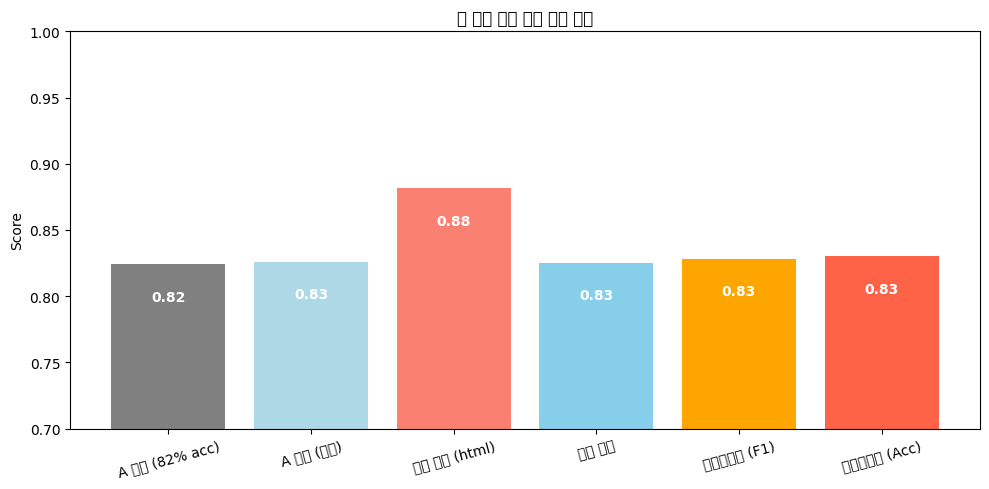

In [155]:
# ✅ 시각화: 조건 맞춘 F1 및 정확도 그래프
import matplotlib.pyplot as plt

labels = [
    'A 모델 (82% acc)', 'A 모델 (기본)', '보조 모델 (html)', '메인 모델', '하이브리드 (F1)', '하이브리드 (Acc)'
]
scores = [
    min_f1, f1_a, f1_b, f1_main, f1_final, acc_final
]
colors = ['gray', 'lightblue', 'salmon', 'skyblue', 'orange', 'tomato']

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, scores, color=colors)
plt.ylim(0.7, 1.0)
plt.ylabel('Score')
plt.title('📊 조건 기반 모델 성능 비교')

# 막대 위에 수치 출력
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.03, f'{height:.2f}',
             ha='center', va='bottom', color='white', fontweight='bold')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()